In [32]:
#importing libraries
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torch.utils.data import Subset,DataLoader

import matplotlib.pyplot as plt

In [33]:
#gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Import dataset

In [58]:
#transformation
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([.5,.5,.5],[.5,.5,.5])
])

#import the data and simulteniously apply transform
trainset = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
devtest = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

#split the devset into two seprate sets
rand_ind = np.random.permutation(10000)   # a random permutation of indices
devset = Subset(devtest,rand_ind[:7000])   # Subset for devset containing 6k instances randomly selected from devset
testset = Subset(devtest,rand_ind[7000:])

#transform to dataloaders
batch_sz = 32
train_loader = DataLoader(trainset,batch_size=batch_sz, shuffle=True, drop_last=True)
dev_loader = DataLoader(devset, batch_size=batch_sz)  #note: devtest
test_loader = DataLoader(testset, batch_size=len(testset))

Files already downloaded and verified
Files already downloaded and verified


In [59]:
# cheking the shape of the datsets
print('Data shapes (train/dev/test) : ')
print(len(trainset))
print(len(devset))
print(len(testset))

# and range of pixel intensity values
print('\nData value range:')
print( np.min(trainset.data), np.max(trainset.data) )

#printing the unique categories
print('\nData Categories: ')
print(trainset.classes)

Data shapes (train/dev/test) : 
50000
7000
3000

Data value range:
0 255

Data Categories: 
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [60]:
X,y = next(iter(train_loader))
print(X.data.shape)

print('\nData value range: ')
print(  (torch.min(X.data),torch.max(X.data)))

torch.Size([32, 3, 32, 32])

Data value range: 
(tensor(-1.), tensor(1.))


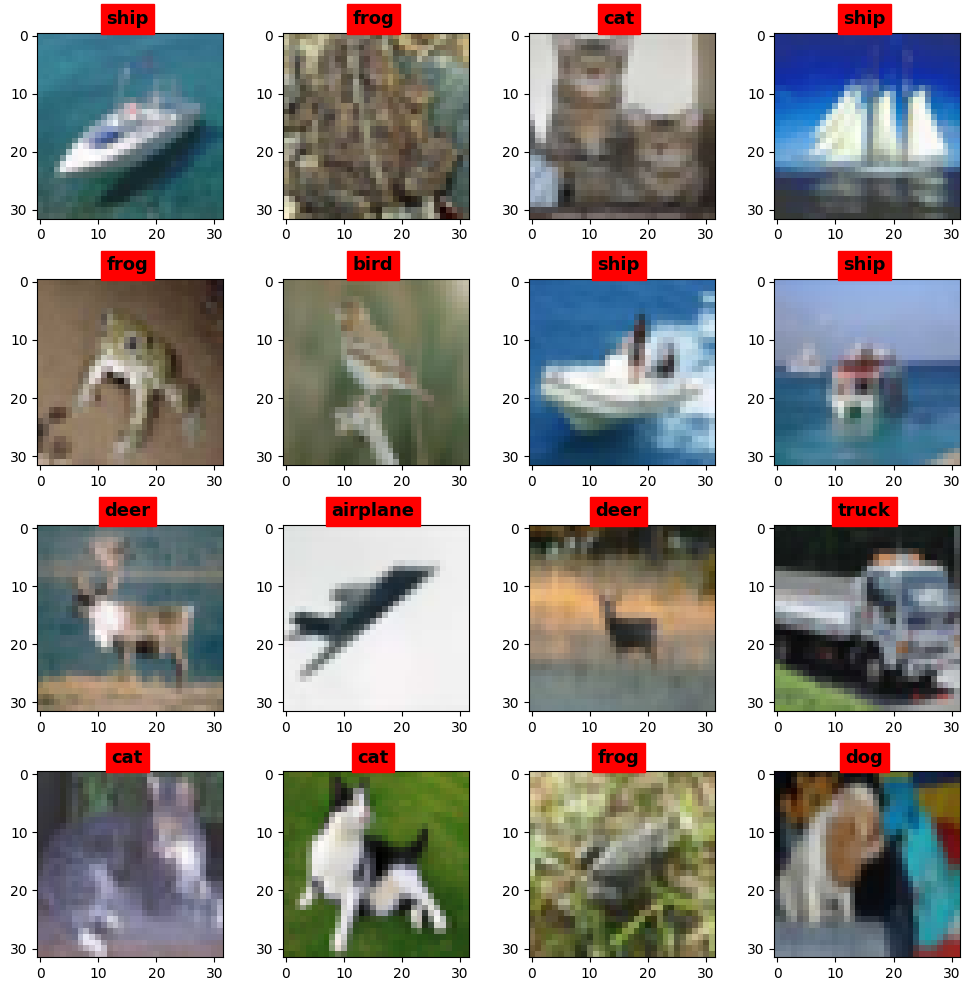

In [61]:
#some image inspections
fig,axs = plt.subplots(4,4,figsize = (10,10),dpi=100)

for (i,ax) in enumerate(axs.flatten()):
    #extractr imag (need to transpose is back to 32x32x3)
    pic = X.data[i].numpy().transpose((1,2,0))  # originally in torch it is --> [3,32,32] not it will be [32,32,3]
    pic = pic/2+.5 #undo normalization

    #label
    label = trainset.classes[y[i]]

    #and show
    ax.imshow(pic)
    ax.text(x=15,y=-2,s=label,fontweight='bold',fontsize=13,ha='center',backgroundcolor='r')
plt.tight_layout()
plt.show()

# Creating the DL model

In [62]:
# create a class for the model
def make_net(printtoggle=False):

  class cnnnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(3,32,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(32) # input the number of channels in this layer
      # output size: (32+2*1-3)/1 + 1 = 32/2 = 16 (/2 b/c maxpool)

      # second convolution layer
      self.conv2  = nn.Conv2d(32,64,3)
      self.bnorm2 = nn.BatchNorm2d(64) # input the number of channels in this layer
      # output size: (16+2*0-3)/1 + 1 = 14/2 = 7 (/2 b/c maxpool)

      # third convolution layer
      self.conv3  = nn.Conv2d(64,128,3)
      self.bnorm3 = nn.BatchNorm2d(128) # input the number of channels in this layer
      # output size: (7+2*0-3)/1 + 1 = 5/2 = 2 (/2 b/c maxpool)

      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(2*2*128,256)
      self.fc2 = nn.Linear(256,64)
      self.fc3 = nn.Linear(64,10)

    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      if self.print: print(f'First CPBR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # third block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv3(x),2)
      x = F.leaky_relu(self.bnorm3(x))
      if self.print: print(f'Third CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorized: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = F.dropout(x,p=.5,training=self.training)
      x = F.leaky_relu(self.fc2(x))
      x = F.dropout(x,p=.5,training=self.training) # training=self.training means to turn off during eval mode
      x = self.fc3(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = cnnnet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=1e-5)

  return net,lossfun,optimizer

In [63]:
# Test model sanity
net,loss_fun,optimizer = make_net()

X,y = next(iter(train_loader))
y_hat = net(X)

#check teh size of the output
print('\nOutput size: ')
print(y_hat.shape)

#computing loss
loss = loss_fun(y_hat,y)
print(' ')
print(loss)


Output size: 
torch.Size([32, 10])
 
tensor(2.3440, grad_fn=<NllLossBackward0>)


# Functions to train the model

In [64]:
#function to train the model
def train_model():
    #create a new model instance
    net,lossfun,optimizer = make_net()

    #send the model to gpu
    net.to(device=device)

    n_epocks = 10

    #initialize losses
    train_loss = torch.zeros(n_epocks)
    dev_loss = torch.zeros(n_epocks)
    train_acc = torch.zeros(n_epocks)
    dev_acc = torch.zeros(n_epocks)

    #loop ober epochs
    for epoch_i in range(n_epocks):

        net.train()
        batch_loss = []
        batch_acc = []

        #loop over training batches
        for X,y in train_loader:
            X = X.to(device)
            y = y.to(device)

            #forward prop and loss
            y_hat = net(X)
            loss = loss_fun(y_hat,y)

            #backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #loss and acccuracy from this step
            batch_loss.append(loss.item())
            batch_acc.append(torch.mean(  (torch.argmax(y_hat,axis=1)==y  ).float() ).item())

        #end of batch loop

        # getting average losses and accuracies across batches
        train_loss[epoch_i] = np.mean(batch_loss)
        train_acc[epoch_i] = 100*np.mean(batch_acc)

        ### test performance
        net.eval()
        batch_acc = []
        batch_loss = []
        for X,y in dev_loader:
            #push data to gpu
            X = X.to(device)
            y = y.to(device)

            #foward prop and loss
            with torch.no_grad():
                y_hat = net(X)
                loss = loss_fun(y_hat,y)

            #loss and accuracy from this batch
            batch_loss.append(loss.item())
            batch_acc.append(  torch.mean(  (torch.argmax(y_hat,axis=1)==y  ).float() ).item())
        #end of batch loops

        #and get avergae losses and accuracies across batchses
        dev_loss[epoch_i] = np.mean(batch_loss)
        dev_acc[epoch_i] = 100*np.mean(batch_acc)
    #end of epochs
    return train_loss,dev_loss,train_acc,dev_acc,net

# Running model and inspecting results

In [65]:
train_loss,dev_loss,train_acc,dev_acc,net=train_model()

In [66]:
# Final test set accuracy inspection

net.eval()
X,y = next(iter(test_loader))

#data to gpu
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.no_grad():
    y_hat = net(X)
    loss = loss_fun(y_hat,y)

# loss nad accuracy from this batch
test_loss = loss.item()
test_acc = 100*torch.mean(  (torch.argmax(y_hat,axis=1) == y).float() ).item()

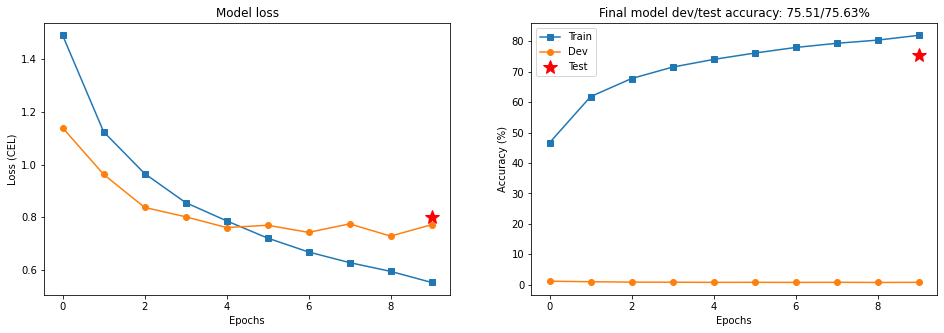

In [67]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(train_loss,'s-',label='Train')
ax[0].plot(dev_loss,'o-',label='Dev')
ax[0].plot(len(dev_loss)-1,test_loss,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(train_acc,'s-',label='Train')
ax[1].plot(dev_loss,'o-',label='Dev')
ax[1].plot(len(dev_acc)-1,test_acc,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {dev_acc[-1]:.2f}/{test_acc:.2f}%')
ax[1].legend()

plt.show()
